# Application of space-group irreps to lattice vibration

This example shows how to prepare representation matrix of atomic displacements by space group, and block-diagonalize dynamical matrix for harmonic lattice vibration only from symmetry.

## Import modules

In [2]:
from pathlib import Path

import phonopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spgrep
from spgrep import get_spacegroup_irreps
from spgrep.representation import check_spacegroup_representation, project_to_irrep

print(f"spgrep=={spgrep.__version__}")

spgrep==0.3.4.dev12+g7a90fec.d20230402


In [3]:
sns.set_context("poster")

## Prepare space-group operations and representation

We consider lattice vibration of Perovskite structure ($Pm\overline{3}m$) at X point.

In [4]:
# Perovskite structure: Pm-3m (No. 221)
a = 3.986
lattice = np.array(
    [
        [a, 0, 0],
        [0, a, 0],
        [0, 0, a],
    ]
)
positions = np.array(
    [
        [0, 0.5, 0.5],  # O(3c)
        [0.5, 0, 0.5],  # O(3c)
        [0.5, 0.5, 0],  # O(3c)
        [0.5, 0.5, 0.5],  # Ti(1b)
        [0, 0, 0],  # Ba(1a)
    ]
)
numbers = [0, 0, 0, 1, 2]

qpoint = [0.5, 0, 0]  # X point (with primitive cell)

Irreps of the space group is obtained by `spgrep.get_spacegroup_irreps`:

In [5]:
irreps, rotations, translations, mapping_little_group = get_spacegroup_irreps(
    lattice, positions, numbers, qpoint
)

# Sanity check if `irreps` are representation for space group
little_rotations = rotations[mapping_little_group]
little_translations = translations[mapping_little_group]
for irrep in irreps:
    assert check_spacegroup_representation(little_rotations, little_translations, qpoint, irrep)

Let $u_{\mu}(l \kappa)$ be a $\mu$-direction atomic displacement of the $\kappa$-th atom in the $l$-th unit cell.
We consider the fourier transformation of $u_{\mu}(l \kappa)$,

$$
  \mathbf{u}(\kappa; \mathbf{q})
    := \sqrt{\frac{M_{\kappa}}{N}} \sum_{l} \mathbf{u}(\mathbf{r}(l\kappa)) e^{ i \mathbf{q} \cdot \mathbf{r}(l) },
$$

where $N$ is number of lattice points in a supercell, and $M_{\kappa}$ is mass of the $\kappa$-th atom.
Let $\mathbf{r}(l\kappa)$ be equilibrium position of the $\kappa$-th atom in the $l$-th unit cell.
The fourier transformation of $u_{\mu}(l \kappa)$ forms representation of space group $\mathcal{G}$ [^1] as

$$
  g u_{\mu}(\kappa; \mathbf{q})
    = \sum_{\kappa'\mu'} u_{\mu'}(\kappa'; \mathbf{R}_{g} \mathbf{q} ) \Gamma_{\kappa'\mu'; \kappa\mu}^{\mathbf{q}}(g)
    \quad (g \in \mathcal{G}),
$$

where $\mathbf{R}_{g}$ represents rotation part of $g$, and

$$
  \Gamma_{\kappa'\mu'; \kappa\mu}^{\mathbf{q}}(g)
    := \exp \left( -i \mathbf{R}_{g} \mathbf{q} \cdot (g \mathbf{r}(0\kappa)) - \mathbf{r}(\mathbf{0}\,g\kappa) \right) [\mathbf{R}_{g}]_{\mu'\mu} \delta_{ g\kappa, \kappa' }.
$$

[^1]: A. A. Maradudin and S. H. Vosko, Rev. Mod. Phys. 40, 1–37 (1968).

In [6]:
def get_displacements_representation(
    lattice,
    positions,
    little_rotations,
    little_translations,
    qpoint,
):
    r"""Compute representation matrix for fourier-transformed displacements.

    .. math::
       \\Gamma_{\\kappa'\\mu'; \\kappa\\mu}^{\\mathbf{q}}(g) := \\exp \\left( -i \\mathbf{R}_{g} \\mathbf{q} \\cdot \\mathbf{h}_{g}(\\kappa) \\right) [\\mathbf{R}_{g}]_{\\mu'\\mu} \\delta_{ g\\kappa, \\kappa' }
    """
    little_order = len(little_rotations)
    num_atoms = len(positions)

    # Operation-`i` moves atom-`kappa` to `permutations[i, kappa]`
    permutations = np.zeros((little_order, num_atoms), dtype=int)
    for i, (Ri, vi) in enumerate(zip(little_rotations, little_translations)):
        for kappa, position in enumerate(positions):
            new_pos = np.remainder(Ri @ position + vi, 1)
            for kappa2, position2 in enumerate(positions):
                if np.allclose(position2, new_pos):
                    permutations[i, kappa] = kappa2
                    break

    shifts = np.zeros((little_order, num_atoms, 3))
    for i, (Ri, vi) in enumerate(zip(little_rotations, little_translations)):
        perm_i = permutations[i]
        shifts[i] = positions @ Ri.T + vi[None, :] - positions[perm_i]

    perm_rep = np.zeros((little_order, num_atoms, num_atoms), dtype=np.complex_)
    for i, Ri in enumerate(little_rotations):
        for kappa in range(num_atoms):
            kappa2 = permutations[i, kappa]
            perm_rep[i, kappa2, kappa] = np.exp(
                -2j * np.pi * np.dot(Ri.T @ qpoint, shifts[i, kappa])
            )

    # Rotation matrix in cartesian (order, 3, 3)
    A = np.transpose(lattice)  # column-wise lattice vectors
    Ainv = np.linalg.inv(A)
    rotation_rep = np.array([A @ r @ Ainv for r in little_rotations], dtype=np.complex_)

    rep = np.einsum("ipq,iab->ipaqb", perm_rep, rotation_rep, optimize="greedy")
    return rep.reshape(-1, num_atoms * 3, num_atoms * 3)


rep = get_displacements_representation(
    lattice, positions, little_rotations, little_translations, qpoint
)

The order of the little co-group at X point is 16, and the atomic displacements are represented by 15 components (x,y,z directions for 5 atoms).
Thus, shape of `rep` is `(16, 15, 15)`.

In [7]:
rep.shape

(16, 15, 15)

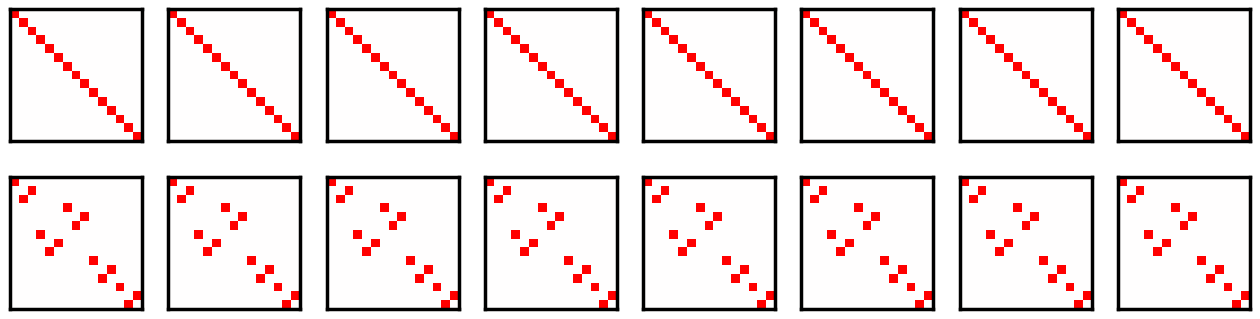

In [8]:
nrows = 2
ncols = 8
fig, axes = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax = axes[row][col]
        ax.imshow(np.abs(rep[idx]), cmap="bwr", vmin=-1, vmax=1)
        ax.set_aspect("equal")
        ax.set_xticks([])
        ax.set_yticks([])

## Load dynamical matrix from PhononDB

Next, we consider to construct a projection operator, and block-diagonalize dynamical matrix at X point.
We use a phonon calculation of Perovskite-BaTiO3 in [PhononDB](http://phonondb.mtl.kyoto-u.ac.jp/ph20180417/d002/mp-2998.html).

In [9]:
# http://phonondb.mtl.kyoto-u.ac.jp/xz-files/phonopy_mp-2998.yaml.xz
path = Path().resolve().parent.parent / "examples" / "phonopy_mp-2998.yaml.xz"
ph = phonopy.load(path)
ph.dynamical_matrix.run(qpoint)
dynamical_matrix = ph.dynamical_matrix.dynamical_matrix

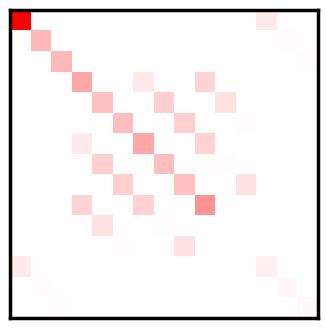

In [10]:
fig, ax = plt.subplots(figsize=(2 * ncols, 2 * nrows))
ax.imshow(np.abs(dynamical_matrix), cmap="bwr", vmin=-1.5, vmax=1.5)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Apply projection operator and block-diagonalize dynamical matrix

2 basis vectors for irrep with (16, 1, 1)
0 basis vectors for irrep with (16, 1, 1)
0 basis vectors for irrep with (16, 1, 1)
2 basis vectors for irrep with (16, 1, 1)
3 basis vectors for irrep with (16, 2, 2)
2 basis vectors for irrep with (16, 2, 2)
1 basis vectors for irrep with (16, 1, 1)
0 basis vectors for irrep with (16, 1, 1)
0 basis vectors for irrep with (16, 1, 1)
0 basis vectors for irrep with (16, 1, 1)


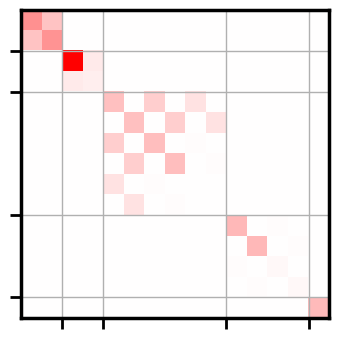

In [11]:
all_basis = []
for irrep in irreps:
    list_basis = project_to_irrep(rep, irrep)
    print(f"{len(list_basis)} basis vectors for irrep with {irrep.shape}")
    all_basis.extend(list_basis)

blocked_dynamical_matrix = (
    np.concatenate(all_basis) @ dynamical_matrix @ np.conj(np.concatenate(all_basis)).T
)

fig, ax = plt.subplots(figsize=(2 * ncols, 2 * nrows))
ax.imshow(np.abs(blocked_dynamical_matrix), cmap="bwr", vmin=-1.5, vmax=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticks([1.5, 3.5, 9.5, 13.5], minor=True)
ax.set_yticks([1.5, 3.5, 9.5, 13.5], minor=True)
ax.grid(which="minor", linewidth=1)
plt.show()